In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

def load_images_and_masks(img_folder, mask_folder, img_size=(256, 256)):
    # Filter out .txt files or any unwanted files
    img_filenames = [f for f in sorted(os.listdir(img_folder)) if not f.endswith('.txt')]
    mask_filenames = [f for f in sorted(os.listdir(mask_folder)) if not f.endswith('.txt')]
    
    images = []
    masks = []
    
    for img_filename, mask_filename in zip(img_filenames, mask_filenames):
        img_path = os.path.join(img_folder, img_filename)
        mask_path = os.path.join(mask_folder, mask_filename)
        
        # Load image and mask
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Paths to the dataset
train_img_folder_path = "/kaggle/input/isic-2018/data/images/train"
train_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/train"
val_img_folder_path = "/kaggle/input/isic-2018/data/images/val"
val_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/val"
test_img_folder_path = "/kaggle/input/isic-2018/data/images/test"
test_mask_folder_path = "/kaggle/input/isic-2018/data/annotations/test"

# Load datasets
train_imgs, train_masks = load_images_and_masks(train_img_folder_path, train_mask_folder_path)
val_imgs, val_masks = load_images_and_masks(val_img_folder_path, val_mask_folder_path)
test_imgs, test_masks = load_images_and_masks(test_img_folder_path, test_mask_folder_path)

# Build the enhanced U-Net model
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def residual_block(input_tensor, num_filters):
    conv = conv_block(input_tensor, num_filters)
    res = layers.Conv2D(num_filters, (1, 1), padding="same")(input_tensor)
    output = layers.add([conv, res])
    return output

def attention_block(g, x, num_filters):
    g1 = layers.Conv2D(num_filters, (1, 1), padding="same")(g)
    g1 = layers.BatchNormalization()(g1)
    x1 = layers.Conv2D(num_filters, (1, 1), padding="same")(x)
    x1 = layers.BatchNormalization()(x1)
    psi = layers.Activation("relu")(layers.add([g1, x1]))
    psi = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(psi)
    return layers.multiply([x, psi])

def build_enhanced_unet(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    f1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(f1)
    p1 = layers.Dropout(0.1)(p1)

    f2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(f2)
    p2 = layers.Dropout(0.1)(p2)

    f3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(f3)
    p3 = layers.Dropout(0.2)(p3)

    f4 = residual_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(f4)
    p4 = layers.Dropout(0.2)(p4)

    # Bottleneck
    bottleneck = residual_block(p4, 1024)
    bottleneck = layers.Dropout(0.3)(bottleneck)

    # Decoder
    u4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    a4 = attention_block(u4, f4, 512)
    c4 = residual_block(a4, 512)

    u3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    a3 = attention_block(u3, f3, 256)
    c3 = residual_block(a3, 256)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c3)
    a2 = attention_block(u2, f2, 128)
    c2 = residual_block(a2, 128)

    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    a1 = attention_block(u1, f1, 64)
    c1 = residual_block(a1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(c1)

    model = models.Model(inputs, outputs)
    return model

model = build_enhanced_unet(input_shape=(256, 256, 3), num_classes=1)


model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ activation_1[0][… │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 29,676,357 (113.21 MB)

 Trainable params: 29,660,741 (113.15 MB)

 Non-trainable params: 15,616 (61.00 KB)

In [2]:
# Compile and train the model
model = build_enhanced_unet(input_shape=(256, 256, 3))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    train_imgs, train_masks,
    validation_data=(val_imgs, val_masks),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


I0000 00:00:1758268060.748186      94 service.cc:145] XLA service 0x7bac34005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758268060.748255      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758268099.744968      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1758268099.786943      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 593ms/step - accuracy: 0.8423 - loss: 0.3927 - mean_io_u: 0.2877 - val_accuracy: 0.7698 - val_loss: 0.4774 - val_mean_io_u: 0.3657
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.8848 - loss: 0.2884 - mean_io_u: 0.2905 - val_accuracy: 0.8757 - val_loss: 0.3140 - val_mean_io_u: 0.3657
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 431ms/step - accuracy: 0.9107 - loss: 0.2360 - mean_io_u: 0.2872 - val_accuracy: 0.8948 - val_loss: 0.2670 - val_mean_io_u: 0.3657
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 432ms/step - accuracy: 0.9244 - loss: 0.2044 - mean_io_u: 0.2890 - val_accuracy: 0.9115 - val_loss: 0.2301 - val_mean_io_u: 0.3657
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9353 - loss: 0.1738 - mean_io_u: 0.2849 - val_accuracy: 0.9064 - val_loss: 0.2544 - val_mean_io_u: 0.3657
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9379 - loss: 0.1655 - mean_io_u: 0.2887 - val_accuracy: 0.8937 - v

In [3]:
# Evaluate the model on test data
test_loss, test_accuracy, test_miou = model.evaluate(test_imgs, test_masks, batch_size=16)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Mean IoU: {test_miou:.4f}")

# Predict on test images
predictions = model.predict(test_imgs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9356 - loss: 0.1890 - mean_io_u: 0.3169
Test Loss: 0.2576
Test Accuracy: 0.9174
Test Mean IoU: 0.2500
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step


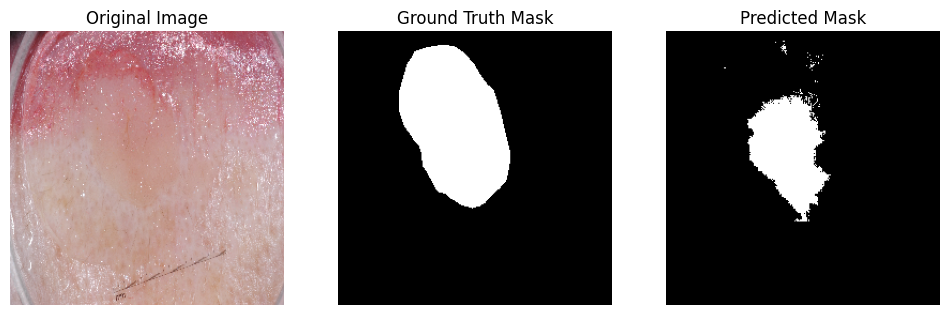

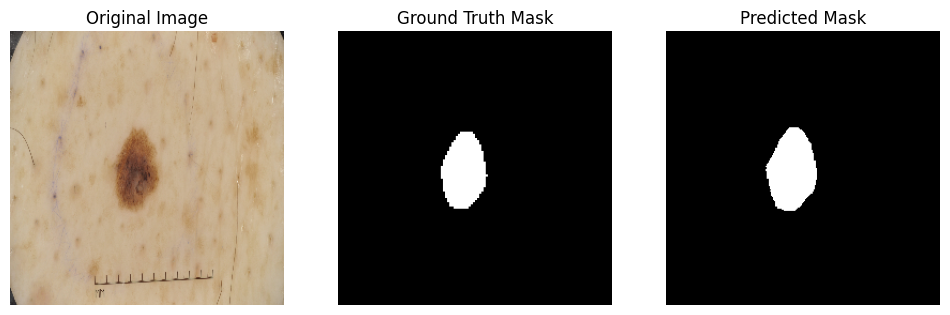

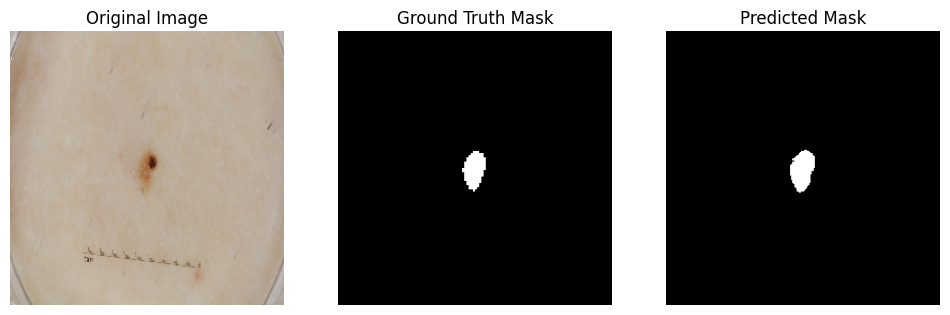

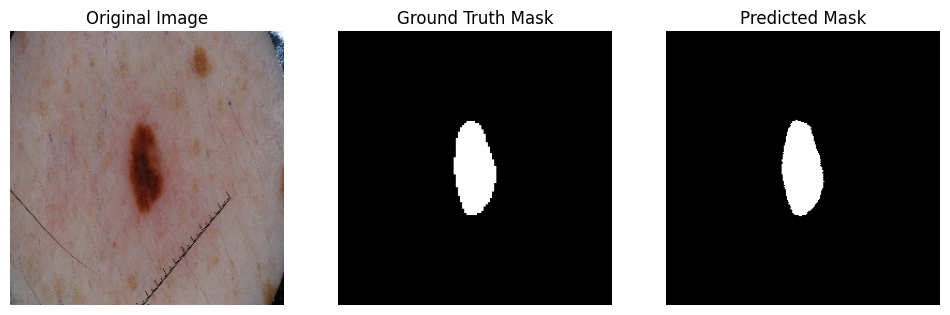

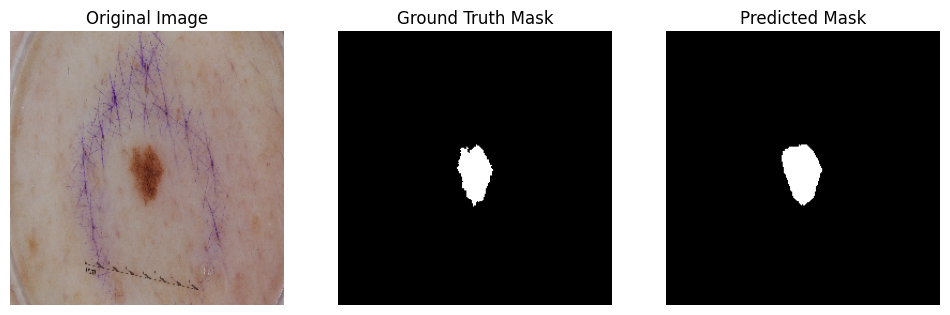

In [4]:
import matplotlib.pyplot as plt

# Function to display original image, ground truth mask, and predicted mask
def display_predictions(images, masks, predictions, num_samples=5):
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis("off")
        
        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        
        plt.show()

# Generate predictions
predictions = model.predict(test_imgs)
predictions = (predictions > 0.5).astype(np.uint8)  # Apply threshold to get binary masks

# Display predictions
display_predictions(test_imgs, test_masks, predictions, num_samples=5)
